## Library loading


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, ReLU, Conv2DTranspose, LeakyReLU, Layer, ZeroPadding2D
from tensorflow.keras.activations import tanh
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

print(tf.__version__)
tf.enable_eager_execution()


1.12.0


## Auxiliary functions

In [5]:
def data_loading(folder,attr_csv, num): 
    ''' data_loading'''
    
    domain_list = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
    list_attr_celeba = pd.read_csv(attr_csv)
    list_attr_celeba = list_attr_celeba.loc[(list_attr_celeba['Black_Hair'] == 1) | (list_attr_celeba['Blond_Hair'] == 1) | (list_attr_celeba['Brown_Hair'] == 1), domain_list]
    list_attr_celeba = list_attr_celeba.replace({-1:0})
    list_attr_celeba = list_attr_celeba.loc[list_attr_celeba.apply(lambda x: x['Black_Hair'] + x['Blond_Hair'] + x['Brown_Hair'], axis=1) == 1, :]
#     list_attr_celeba = list_attr_celeba.loc[:, domain_list]
    
    if type(num) == int:
        list_attr_celeba = list_attr_celeba.sample(n=num,replace=False)
    else:
        num = len(list_attr_celeba)

    idx = list(list_attr_celeba.index)
    img_list = glob.glob(os.path.join(folder, '*'))
    h, w, c = np.array(Image.open(img_list[0])).shape
    X_train = np.zeros((num, h, w, c))
    cnt = 0
    
    for img_idx in tqdm(idx):
        X_train[cnt] = (np.array(Image.open(img_list[img_idx])) - 127.5) / 127.5            
        cnt += 1
            
    print("{} images loaded ".format(len(X_train)))
    print("{} x {} original domain lables loaded".format(list_attr_celeba.shape[0], list_attr_celeba.shape[1]))
    
    return X_train, np.array(list_attr_celeba)

def dataset_split(X_train, y_train, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size)
    print("Number of train images: {}".format(len(X_train)))
    print("Number of train original domain labels: {}".format(len(y_train)))
    print("Number of test images: {}".format(len(X_test)))
    print("Number of test original domain labels: {}".format(len(y_test)))
    return X_train, X_test, y_train, y_test

def _preprocessing(image, domain, resize, mode): 
    ''' image flip & domain reshape'''
    if mode == 'train':
        image = tf.image.random_flip_left_right(image)        
    image = tf.image.central_crop(image, central_fraction=float(178/215))
    image = tf.image.resize_images(image, [resize, resize])
    domain = tf.reshape(domain, shape=(-1,1, 1, tf.shape(domain)[-1])) 
    return image,domain

def random_target_domain_generation(train_batch_size):
  ''' target domain generation '''
  target_domain_1 = np.random.uniform(low=0., high=3., size=train_batch_size).astype(np.int32) # facial expression attributes
  target_domain_1 = tf.one_hot(target_domain_1, depth=3)
  target_domain_2 = np.random.randint(2, size=(train_batch_size,2))   # male, young attributes
  target_domain =  np.concatenate([target_domain_1, target_domain_2], axis=-1)
  target_domain = target_domain.reshape((target_domain.shape[0],1,1,target_domain.shape[1]))
  return target_domain

def fake_image_gp_generator(input_image, fake_image): 
    batch_size = input_image.shape[0]
    epsilon = tf.random.uniform([batch_size])
    input_image = np.array(input_image) 
    for i in range(batch_size):      
      input_image[i] = epsilon[i] * input_image[i]
    return tf.cast(input_image, tf.float32) 

def generate_and_save_images(model, step, test_iterator, saving_folder):
  ''' generated image saving'''

  test_image, _ = test_iterator.get_next()
  target_domain = random_target_domain_generation(tf.shape(test_image)[0])
  predictions = model(test_image, target_domain)
  fig = plt.figure(figsize=(20,20))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
    plt.axis('off')        
  plt.savefig(saving_folder + '/' + 'image_at_step_{:04d}.png'.format(step))
  plt.show()
  
def input_merge(images, domain):
  ''' input image and domain merge'''
  batch_size = images.shape[0]
  image_size = images.shape[1] 
  channels = domain.shape[-1] 
  domain = np.squeeze(domain, axis=(1,2))  
  merged = np.zeros([batch_size,image_size,image_size,channels])
  for batch in range(batch_size):
    temp = tf.broadcast_to(domain[batch], [image_size,image_size,channels])
    merged[batch] = temp
  merged = tf.concat([images, merged], axis=-1)
  return merged  

def lookup(domain):
    lookup_table = np.array(['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young', 'Female', 'Old'])
    domain = np.array(domain)[0,0,:].astype('int64')
    idx = np.where(domain>0)[0]
    if domain[3] == 0:
        idx = np.concatenate([idx,[5]])
    if domain[4] == 0:
        idx = np.concatenate([idx,[6]])
    return lookup_table[idx]

#### InstanceNormalization code (https://github.com/ilguyi/generative.models.tensorflow.v2/tree/master/gans)
class InstanceNormalization(tf.keras.layers.Layer):
      def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
      def build(self, input_shape):
       shape = tf.TensorShape(input_shape)
       param_shape = shape[-1]
       # Create a trainable weight variable for this layer.
       self.gamma = self.add_weight(name='gamma',
                                    shape=param_shape,
                                    initializer='ones',
                                    trainable=True)
       self.beta = self.add_weight(name='beta',
                                   shape=param_shape,
                                   initializer='zeros',
                                   trainable=True)
      def call(self, inputs):
       input_shape = inputs.get_shape()
       reduction_axes = [1, 2] # only shape index\n",
       mean, variance = tf.nn.moments(inputs, reduction_axes, keep_dims=True)
       normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
       return self.gamma * normalized + self.beta


## Network structures

In [6]:
class Downsampling_Part(tf.keras.Model):
  ''' Downsampling part of Generator'''
  
  def __init__(self):
    super(Downsampling_Part, self).__init__()
    self.conv1 = Conv2D(64, kernel_size = 7, strides = 1, padding = 'valid')
    self.conv2 = Conv2D(128, kernel_size = 4, strides = 2, padding = 'valid')
    self.conv3 = Conv2D(256, kernel_size = 4, strides = 2, padding = 'valid')
    self.zeropadding1 = ZeroPadding2D(3)
    self.zeropadding2 = ZeroPadding2D(1)
    self.zeropadding3 = ZeroPadding2D(1)
    self.in1 = InstanceNormalization()
    self.in2 = InstanceNormalization()
    self.in3 = InstanceNormalization()
    self.activation_ReLU = ReLU()
  
  def call(self, images, labels):
    x = input_merge(images,labels)
    x = self.zeropadding1(x)
    x = self.conv1(x)
    x = self.in1(x)
    x = self.activation_ReLU(x)

    x = self.zeropadding2(x)
    x = self.conv2(x)
    x = self.in2(x)
    x = self.activation_ReLU(x)

    x = self.zeropadding3(x)
    x = self.conv3(x)
    x = self.in3(x)
    x = self.activation_ReLU(x)
    return x
  

class ResnetIdentityBlock(tf.keras.Model):
  ''' ResentIdentityBlock for Residual part of Generator'''
  
  def __init__(self):
    super(ResnetIdentityBlock, self).__init__()
    self.conv1 = Conv2D(filters=256, kernel_size=3, strides=1, padding='valid')
    self.conv2 = Conv2D(filters=256, kernel_size=3, strides=1, padding='valid')
    self.zeropadding = ZeroPadding2D(1)
    self.in1 = InstanceNormalization()
    self.activation_ReLU = ReLU()

  def call(self, input_tensor):
    x = self.zeropadding(input_tensor)
    x = self.conv1(x)
    x = self.in1(x)
    x = self.activation_ReLU(x)
    x = self.zeropadding(x)
    x = self.conv2(x)
    x += input_tensor
    x = self.activation_ReLU(x)
    return x

  
class Bottleneck_Part(tf.keras.Model):
  ''' Bottleneck part of Generator'''
  def __init__(self):
    super(Bottleneck_Part, self).__init__()
    self.ResnetIdentityBlock = ResnetIdentityBlock()
    
  def call(self, input_tensor):
    x  = self.ResnetIdentityBlock(input_tensor)
    x  = self.ResnetIdentityBlock(x)
    x  = self.ResnetIdentityBlock(x)
    x  = self.ResnetIdentityBlock(x)
    x  = self.ResnetIdentityBlock(x)
    x  = self.ResnetIdentityBlock(x)       
    return x
  

class Upsampling_Part(tf.keras.Model):
  ''' Upsampling part of Generator'''
  
  def __init__(self):
    super(Upsampling_Part, self).__init__()
    self.deconv1 = Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same')
    self.deconv2 = Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = 'same')
    self.conv1 = Conv2D(3, kernel_size = 7, strides = 1, padding = 'same')
    self.zeropadding1 = ZeroPadding2D(1)
    self.zeropadding2 = ZeroPadding2D(1)
    self.zeropadding3 = ZeroPadding2D(3)
    self.activation_ReLU = ReLU()
    self.in1 = InstanceNormalization()
    self.in2 = InstanceNormalization()

    
  def call(self, x):
    x = self.deconv1(x)
    x = self.in1(x)
    x = self.activation_ReLU(x)

    x = self.deconv2(x)
    x = self.in2(x)
    x = self.activation_ReLU(x)

    x = self.conv1(x)
    x = tanh(x)
    return x
  
  
class Build_generator(tf.keras.Model):
  ''' Building a generator'''
  def __init__(self):
    super(Build_generator, self).__init__()
    self.Downsampling = Downsampling_Part()
    self.ResidualBlock = Bottleneck_Part()
    self.Upsampling = Upsampling_Part()
    
  def call(self, images, labels):
    x = self.Downsampling(images, labels)
    x = self.ResidualBlock(x)
    x = self.Upsampling(x)
    return x
 

class Build_discriminator(tf.keras.Model):
  ''' Building a discriminator'''
  
  def __init__(self, image_size, nd):
    super(Build_discriminator, self).__init__()
    self.conv1 = Conv2D(64, kernel_size = 4, strides = 2, padding = 'valid')
    self.conv2 = Conv2D(128, kernel_size = 4, strides = 2, padding = 'valid')
    self.conv3 = Conv2D(256, kernel_size = 4, strides = 2, padding = 'valid')
    self.conv4 = Conv2D(512, kernel_size = 4, strides = 2, padding = 'valid')
    self.conv5 = Conv2D(1024, kernel_size = 4, strides = 2, padding = 'valid')
    self.conv6 = Conv2D(2048, kernel_size = 4, strides = 2, padding = 'valid')    
    self.conv7_1 = Conv2D(1, kernel_size = 3, strides = 1)    
    self.conv7_2 = Conv2D(nd, kernel_size = int(image_size/64), strides = 1)    
    self.zeropadding0 = ZeroPadding2D(0) 
    self.zeropadding = ZeroPadding2D(1)
    self.activation_LeakyReLU = LeakyReLU(alpha=0.01)
    
  def call(self, x):
    x = self.zeropadding(x)
    x = self.conv1(x)
    x = self.activation_LeakyReLU(x)

    x = self.zeropadding(x)
    x = self.conv2(x)
    x = self.activation_LeakyReLU(x)
    
    x = self.zeropadding(x)
    x = self.conv3(x)
    x = self.activation_LeakyReLU(x)
    
    x = self.zeropadding(x)
    x = self.conv4(x)
    x = self.activation_LeakyReLU(x)

    x = self.zeropadding(x)
    x = self.conv5(x)
    x = self.activation_LeakyReLU(x)

    x = self.zeropadding(x)
    x = self.conv6(x)
    x = self.activation_LeakyReLU(x)
    
    x_src = self.zeropadding(x)
    D_src = self.conv7_1(x_src)
    D_cls = self.conv7_2(x)

    return  D_src, D_cls

## Loss

In [7]:
### Loss
def reconstruction_loss(image,rec_image):
  return lambda_rec * tf.reduce_mean(np.abs(image  - rec_image))
 
def domain_cls_loss(domain, logits):
  return lambda_cls * tf.losses.sigmoid_cross_entropy(multi_class_labels = domain, logits = logits)

def adverserial_loss(logits):
  loss = tf.reduce_mean(logits)
  return loss

def gradient_penalty(gp_D_src_grad):
    l2_norm = tf.sqrt(tf.reduce_sum(gp_D_src_grad**2))
    return (l2_norm-1)**2
    
def G_loss(fake_D_src, target_D_cls, target_domain,input_image, reconstructed_image, lambda_cls,lambda_rec):
  loss = -adverserial_loss(fake_D_src) + lambda_cls * domain_cls_loss(target_domain, target_D_cls) + lambda_rec * reconstruction_loss(input_image, reconstructed_image)
  return loss
  
def D_loss(real_D_src, fake_D_src, original_domain, original_D_cls, lambda_cls, lambda_gp, gp_D_src_grad):
  loss = -adverserial_loss(real_D_src) + adverserial_loss(fake_D_src)  + lambda_gp*gradient_penalty(gp_D_src_grad) + lambda_cls* domain_cls_loss(original_domain,original_D_cls)
  return loss


## Optimizer

In [8]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

## Train loop (training happens here)

In [2]:
def train_step(input_image, original_domain, step, i,discriminator_updates):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    # step(b)
    target_domain = random_target_domain_generation(train_batch_size) 
    fake_image = generator(input_image, target_domain)  

    # step(d)
    fake_D_src, target_D_cls = discriminator(fake_image)  
    
    # step(c)
    reconstructed_image = generator(fake_image, original_domain) 
    
    # stsp(a)
    real_D_src, original_D_cls = discriminator(input_image)  
    
    # fake_image for WGAN-GP lossfake_image
    fake_image_gp = fake_image_gp_generator(input_image, fake_image)

    # WGAN-GP loss
    with tf.GradientTape() as gp_tape:
      gp_tape.watch(fake_image_gp)
      gp_D_src, _  = discriminator(fake_image_gp)
      gp_D_src_grad = gp_tape.gradient(gp_D_src, fake_image_gp)  

    discriminator_loss = D_loss(real_D_src, fake_D_src, original_domain, original_D_cls, lambda_cls, lambda_gp, gp_D_src_grad)
    generator_loss = G_loss(fake_D_src, target_D_cls, target_domain,input_image, reconstructed_image, lambda_cls,lambda_rec)

   # discriminator updates
  gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  if (step + 1) % loss_print_period == 0:
        print ("Step %d-%d [D loss: %f]" % (step+1, i+1, discriminator_loss))   

  # generator update
  if i+1 == discriminator_updates: 
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    if (step + 1) % loss_print_period == 0:
        print ("Step %d [G loss: %f]" % (step+1, generator_loss))    

def train(train_iterator, test_iterator, total_step, train_batch_size,discriminator_updates, saving_folder,image_saving_period):    
    for step in tqdm(range(total_step)):            
        start = time.time()
        
        for i in range(discriminator_updates):
            input_image, original_domain = train_iterator.get_next()
            train_step(input_image, original_domain, step, i,discriminator_updates)  
        
        if (step + 1) % image_saving_period == 0:
            generate_and_save_images(generator,
                                 step + 1,
                                 test_iterator,
                                 saving_folder)
            checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for step {} is {} sec'.format(step + 1, time.time()-start))


## Execution

#### Dataset prepration

In [10]:
attr_csv = '/home/Markkim/Celeb/list_attr_celeba.csv'
folder = '/home/Markkim/Celeb/img_align_celeba/'
num = 'all'

X_train, original_domain = data_loading(folder, attr_csv, num)
X_train, X_test, original_domain_train, original_domain_test = dataset_split(X_train, original_domain, test_size=0.2)

100%|██████████| 115309/115309 [05:38<00:00, 340.79it/s]


115309 images loaded 
115309 x 5 original domain lables loaded
Number of train images: 92247
Number of train original domain labels: 92247
Number of test images: 23062
Number of test original domain labels: 23062


#### tf.dataset generation


In [15]:
train_batch_size = 16
test_batch_size = 4
resize = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,original_domain_train))
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(train_batch_size) 
train_dataset = train_dataset.map(lambda x, y: _preprocessing(x, y, resize, mode='train'))
train_iterator = train_dataset.make_one_shot_iterator()

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,original_domain_test))
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(test_batch_size) 
test_dataset = test_dataset.map(lambda x, y: _preprocessing(x, y, resize, mode='test'))
test_iterator = test_dataset.make_one_shot_iterator()

#### model building

In [16]:
generator = Build_generator()
discriminator = Build_discriminator(resize, original_domain_train.shape[-1])

##### checkpoint

In [17]:
checkpoint_dir = '/home/Markkim/stargan4/'
# os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator)

#### Training


  1%|          | 283/55000 [11:55<38:10:52,  2.51s/it]


  1%|          | 565/55000 [23:48<39:06:27,  2.59s/it]


  2%|▏         | 847/55000 [35:36<37:07:29,  2.47s/it]


  2%|▏         | 1127/55000 [47:18<35:41:27,  2.39s/it]


  3%|▎         | 1403/55000 [59:04<39:04:49,  2.62s/it]


  3%|▎         | 1672/55000 [1:10:28<37:15:14,  2.51s/it]


  4%|▎         | 1940/55000 [1:21:43<37:29:12,  2.54s/it]


  4%|▍         | 2208/55000 [1:33:00<36:42:19,  2.50s/it]


  5%|▍         | 2476/55000 [1:44:15<37:18:06,  2.56s/it]


  5%|▍         | 2744/55000 [1:55:27<34:41:18,  2.39s/it]


  5%|▌         | 3012/55000 [2:06:06<33:00:35,  2.29s/it]


  6%|▌         | 3280/55000 [2:16:14<32:47:06,  2.28s/it]


  6%|▋         | 3548/55000 [2:26:24<33:02:55,  2.31s/it]


  7%|▋         | 3816/55000 [2:36:32<33:35:49,  2.36s/it]


  7%|▋         | 4084/55000 [2:46:45<31:54:47,  2.26s/it]


  8%|▊         | 4352/55000 [2:56:54<31:30:07,  2.24s/it]


  8%|▊         | 4620/55000 [3:07:05<32:11:58,  2.30s/it]


  9%|▉         | 4888/55000 [3:17:13<31:05:44,  2.23s/it]


  9%|▉         | 5156/55000 [3:27:28<31:31:12,  2.28s/it]


 10%|▉         | 5424/55000 [3:37:38<31:16:29,  2.27s/it]


 10%|▉         | 5499/55000 [3:40:29<31:22:29,  2.28s/it]

Step 5500-1 [D loss: -2.541886]
Step 5500-2 [D loss: -1.575335]
Step 5500-3 [D loss: -1.879320]
Step 5500-4 [D loss: -1.113852]
Step 5500-5 [D loss: -0.531425]
Step 5500 [G loss: 29.315359]


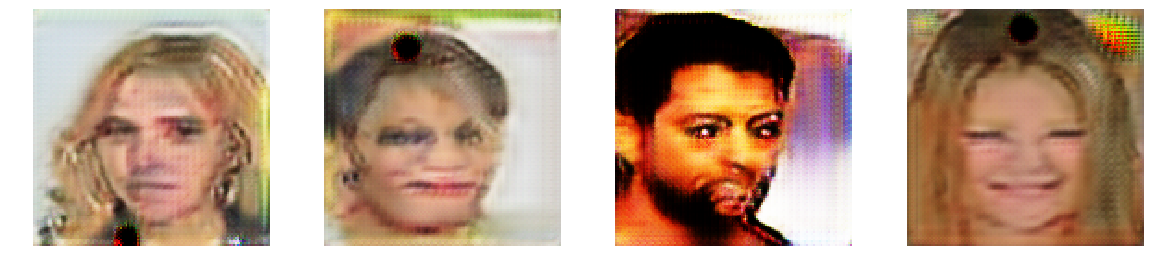


 10%|█         | 5500/55000 [3:40:34<42:34:29,  3.10s/it]

Time for step 5500 is 4.994374752044678 sec



 10%|█         | 5768/55000 [3:50:43<31:02:59,  2.27s/it]


 11%|█         | 6036/55000 [4:00:59<30:53:34,  2.27s/it]


 11%|█▏        | 6304/55000 [4:11:17<31:28:31,  2.33s/it]


 12%|█▏        | 6572/55000 [4:21:27<30:53:35,  2.30s/it]


 12%|█▏        | 6840/55000 [4:31:37<30:35:29,  2.29s/it]


 13%|█▎        | 7108/55000 [4:41:50<31:11:11,  2.34s/it]


 13%|█▎        | 7376/55000 [4:52:05<29:38:33,  2.24s/it]


 14%|█▍        | 7644/55000 [5:02:21<29:53:12,  2.27s/it]


 14%|█▍        | 7912/55000 [5:12:31<29:49:40,  2.28s/it]


 15%|█▍        | 8180/55000 [5:22:38<29:32:17,  2.27s/it]


 15%|█▌        | 8448/55000 [5:32:55<30:22:33,  2.35s/it]


 16%|█▌        | 8716/55000 [5:43:11<28:52:53,  2.25s/it]


 16%|█▋        | 8984/55000 [5:53:19<28:23:26,  2.22s/it]


 17%|█▋        | 9252/55000 [6:03:27<28:29:52,  2.24s/it]


 17%|█▋        | 9520/55000 [6:13:40<29:13:02,  2.31s/it]


 18%|█▊        | 9788/55000 [6:23:55<29:45:01,  2.37s/it]


 18%|█▊        | 10055/55000 [6:34:05<27:51:15,  2.23s/it]


 19%|█▉        | 10319/55000 [6:44:06<27:51:25,  2.24s/it]


 19%|█▉        | 10583/55000 [6:54:05<28:37:21,  2.32s/it]


 20%|█▉        | 10847/55000 [7:04:08<28:18:10,  2.31s/it]


 20%|█▉        | 10999/55000 [7:10:00<28:18:19,  2.32s/it]

Step 11000-1 [D loss: -1.228471]
Step 11000-2 [D loss: -1.272656]
Step 11000-3 [D loss: -0.460339]
Step 11000-4 [D loss: -0.778108]
Step 11000-5 [D loss: -1.570049]
Step 11000 [G loss: 34.353863]


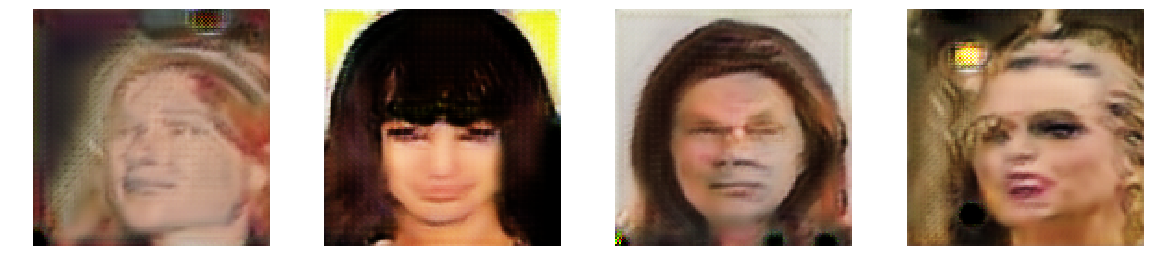


 20%|██        | 11000/55000 [7:10:06<41:01:19,  3.36s/it]

Time for step 11000 is 5.781121253967285 sec



 20%|██        | 11264/55000 [7:20:05<27:36:35,  2.27s/it]


 21%|██        | 11528/55000 [7:30:04<26:51:33,  2.22s/it]


 21%|██▏       | 11792/55000 [7:40:03<27:48:31,  2.32s/it]


 22%|██▏       | 12056/55000 [7:50:04<27:58:57,  2.35s/it]


 22%|██▏       | 12320/55000 [8:00:07<26:46:52,  2.26s/it]


 23%|██▎       | 12584/55000 [8:10:07<26:24:41,  2.24s/it]


 23%|██▎       | 12848/55000 [8:20:00<26:22:34,  2.25s/it]


 24%|██▍       | 13112/55000 [8:30:02<26:16:57,  2.26s/it]


 24%|██▍       | 13376/55000 [8:40:08<26:49:04,  2.32s/it]


 25%|██▍       | 13640/55000 [8:50:09<25:36:12,  2.23s/it]


 25%|██▌       | 13904/55000 [9:00:07<26:27:59,  2.32s/it]


 26%|██▌       | 14168/55000 [9:10:04<26:01:20,  2.29s/it]


 26%|██▌       | 14432/55000 [9:20:04<25:06:33,  2.23s/it]


 27%|██▋       | 14696/55000 [9:30:07<25:25:13,  2.27s/it]


 27%|██▋       | 14960/55000 [9:40:08<25:34:27,  2.30s/it]


 28%|██▊       | 15224/55000 [9:50:03<25:09:02,  2.28s/it]


 28%|██▊       | 15488/55000 [10:00:00<24:45:09,  2.26s/it]


 29%|██▊       | 15748/55000 [10:09:57<25:06:35,  2.30s/it]


 29%|██▉       | 16008/55000 [10:19:47<24:02:23,  2.22s/it]


 30%|██▉       | 16268/55000 [10:29:35<24:11:20,  2.25s/it]


 30%|██▉       | 16499/55000 [10:38:16<24:16:04,  2.27s/it]

Step 16500-1 [D loss: -0.750884]
Step 16500-2 [D loss: -0.536353]
Step 16500-3 [D loss: -1.182454]
Step 16500-4 [D loss: -0.309351]
Step 16500-5 [D loss: -0.687999]
Step 16500 [G loss: 27.805738]


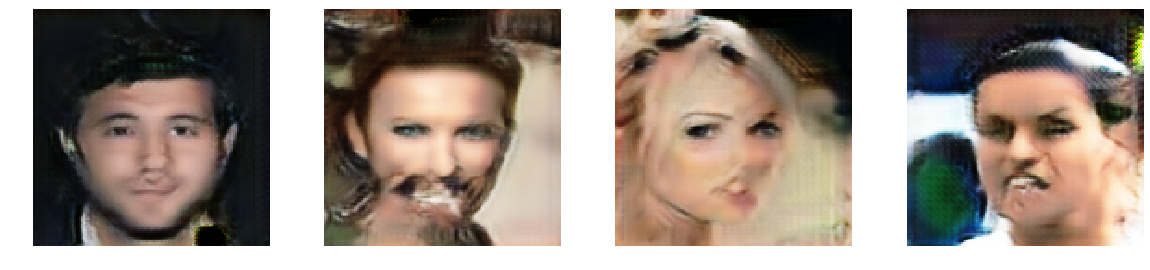


 30%|███       | 16500/55000 [10:38:21<32:21:19,  3.03s/it]

Time for step 16500 is 4.786964178085327 sec



 30%|███       | 16760/55000 [10:48:12<25:07:30,  2.37s/it]


 31%|███       | 17020/55000 [10:58:09<24:05:46,  2.28s/it]


 31%|███▏      | 17280/55000 [11:08:00<23:37:38,  2.25s/it]


 32%|███▏      | 17540/55000 [11:17:45<23:01:07,  2.21s/it]


 32%|███▏      | 17800/55000 [11:27:33<23:35:57,  2.28s/it]


 33%|███▎      | 18060/55000 [11:37:30<23:08:11,  2.25s/it]


 33%|███▎      | 18320/55000 [11:47:21<23:23:52,  2.30s/it]


 34%|███▍      | 18580/55000 [11:57:08<23:13:07,  2.30s/it]


 34%|███▍      | 18840/55000 [12:06:54<23:38:21,  2.35s/it]


 35%|███▍      | 19100/55000 [12:16:44<23:02:21,  2.31s/it]


 35%|███▌      | 19360/55000 [12:26:40<22:37:44,  2.29s/it]


 36%|███▌      | 19620/55000 [12:36:29<22:01:58,  2.24s/it]


 36%|███▌      | 19880/55000 [12:46:13<22:33:05,  2.31s/it]


 37%|███▋      | 20140/55000 [12:55:58<21:41:05,  2.24s/it]


 37%|███▋      | 20400/55000 [13:05:54<22:17:08,  2.32s/it]


 38%|███▊      | 20660/55000 [13:15:44<21:24:44,  2.24s/it]


 38%|███▊      | 20920/55000 [13:25:31<21:16:00,  2.25s/it]


 39%|███▊      | 21180/55000 [13:35:15<21:25:54,  2.28s/it]


 39%|███▉      | 21440/55000 [13:45:02<21:13:48,  2.28s/it]


 39%|███▉      | 21700/55000 [13:54:58<21:08:51,  2.29s/it]


 40%|███▉      | 21960/55000 [14:04:47<20:45:41,  2.26s/it]


 40%|███▉      | 21999/55000 [14:06:15<20:38:41,  2.25s/it]

Step 22000-1 [D loss: -0.838536]
Step 22000-2 [D loss: -1.047048]
Step 22000-3 [D loss: -0.831824]
Step 22000-4 [D loss: -0.247101]
Step 22000-5 [D loss: -1.344979]
Step 22000 [G loss: 32.049351]


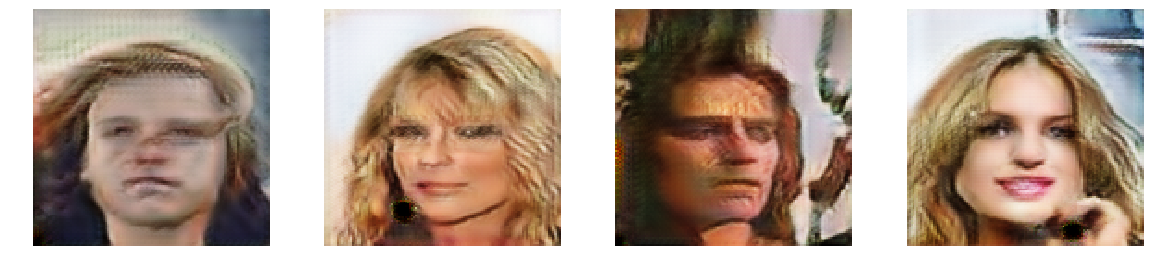


 40%|████      | 22000/55000 [14:06:19<27:28:46,  3.00s/it]

Time for step 22000 is 4.734796524047852 sec



 40%|████      | 22260/55000 [14:16:03<20:46:09,  2.28s/it]


 41%|████      | 22520/55000 [14:25:47<20:00:39,  2.22s/it]


 41%|████▏     | 22780/55000 [14:35:43<20:30:09,  2.29s/it]


 42%|████▏     | 23040/55000 [14:45:32<19:44:43,  2.22s/it]


 42%|████▏     | 23300/55000 [14:55:16<19:44:09,  2.24s/it]


 43%|████▎     | 23560/55000 [15:05:00<19:22:25,  2.22s/it]


 43%|████▎     | 23820/55000 [15:14:47<19:47:01,  2.28s/it]


 44%|████▍     | 24080/55000 [15:24:40<19:55:21,  2.32s/it]


 44%|████▍     | 24340/55000 [15:34:20<19:06:59,  2.24s/it]


 45%|████▍     | 24600/55000 [15:43:54<19:01:13,  2.25s/it]


 45%|████▌     | 24860/55000 [15:53:29<18:41:19,  2.23s/it]


 46%|████▌     | 25120/55000 [16:03:08<18:40:38,  2.25s/it]


 46%|████▌     | 25380/55000 [16:12:48<18:32:06,  2.25s/it]


 47%|████▋     | 25640/55000 [16:22:21<17:46:59,  2.18s/it]


 47%|████▋     | 25900/55000 [16:31:55<17:37:52,  2.18s/it]


 48%|████▊     | 26160/55000 [16:41:29<18:12:32,  2.27s/it]


 48%|████▊     | 26420/55000 [16:51:10<17:29:52,  2.20s/it]


 49%|████▊     | 26680/55000 [17:00:45<17:12:28,  2.19s/it]


 49%|████▉     | 26940/55000 [17:10:20<17:38:04,  2.26s/it]


 49%|████▉     | 27200/55000 [17:20:02<17:34:08,  2.28s/it]


 50%|████▉     | 27460/55000 [17:29:46<17:20:51,  2.27s/it]


 50%|████▉     | 27499/55000 [17:31:14<17:22:14,  2.27s/it]

Step 27500-1 [D loss: -0.652135]
Step 27500-2 [D loss: -0.598517]
Step 27500-3 [D loss: -0.765743]
Step 27500-4 [D loss: -0.923173]
Step 27500-5 [D loss: -0.592046]
Step 27500 [G loss: 29.453043]


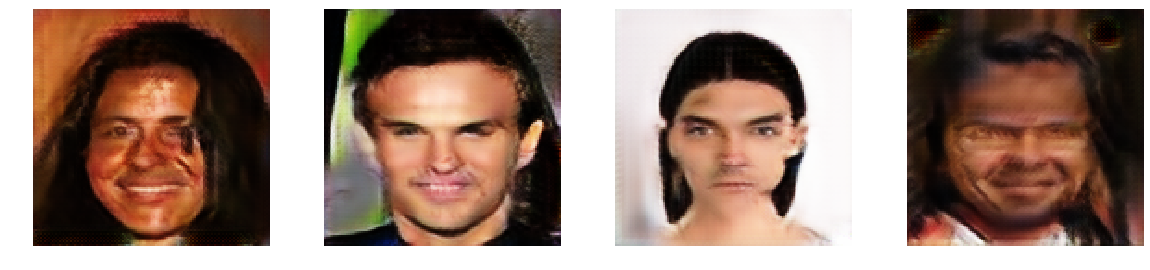


 50%|█████     | 27500/55000 [17:31:18<20:56:32,  2.74s/it]

Time for step 27500 is 3.8295090198516846 sec



 50%|█████     | 27760/55000 [17:41:03<17:02:19,  2.25s/it]


 51%|█████     | 28020/55000 [17:50:45<17:01:41,  2.27s/it]


 51%|█████▏    | 28280/55000 [18:00:28<16:56:12,  2.28s/it]


 52%|█████▏    | 28540/55000 [18:10:10<16:52:49,  2.30s/it]


 52%|█████▏    | 28800/55000 [18:19:56<16:38:26,  2.29s/it]


 53%|█████▎    | 29060/55000 [18:29:38<16:21:47,  2.27s/it]


 53%|█████▎    | 29320/55000 [18:39:20<15:58:02,  2.24s/it]


 54%|█████▍    | 29580/55000 [18:49:01<16:01:34,  2.27s/it]


 54%|█████▍    | 29840/55000 [18:58:43<15:30:07,  2.22s/it]


 55%|█████▍    | 30100/55000 [19:08:27<15:10:55,  2.19s/it]


 55%|█████▌    | 30360/55000 [19:18:09<15:18:49,  2.24s/it]


 56%|█████▌    | 30620/55000 [19:27:51<15:02:38,  2.22s/it]


 56%|█████▌    | 30880/55000 [19:37:33<14:54:45,  2.23s/it]


 57%|█████▋    | 31140/55000 [19:47:16<14:38:02,  2.21s/it]


 57%|█████▋    | 31400/55000 [19:56:58<14:35:40,  2.23s/it]


 58%|█████▊    | 31660/55000 [20:06:39<14:20:03,  2.21s/it]


 58%|█████▊    | 31920/55000 [20:16:19<14:25:42,  2.25s/it]


 59%|█████▊    | 32180/55000 [20:25:52<14:00:06,  2.21s/it]


 59%|█████▉    | 32440/55000 [20:35:27<13:39:17,  2.18s/it]


 59%|█████▉    | 32700/55000 [20:45:01<13:37:10,  2.20s/it]


 60%|█████▉    | 32960/55000 [20:54:38<13:55:28,  2.27s/it]


 60%|█████▉    | 32999/55000 [20:56:05<13:56:27,  2.28s/it]

Step 33000-1 [D loss: -0.662749]
Step 33000-2 [D loss: -0.572237]
Step 33000-3 [D loss: -0.811284]
Step 33000-4 [D loss: -0.731656]
Step 33000-5 [D loss: -0.358838]
Step 33000 [G loss: 24.592770]


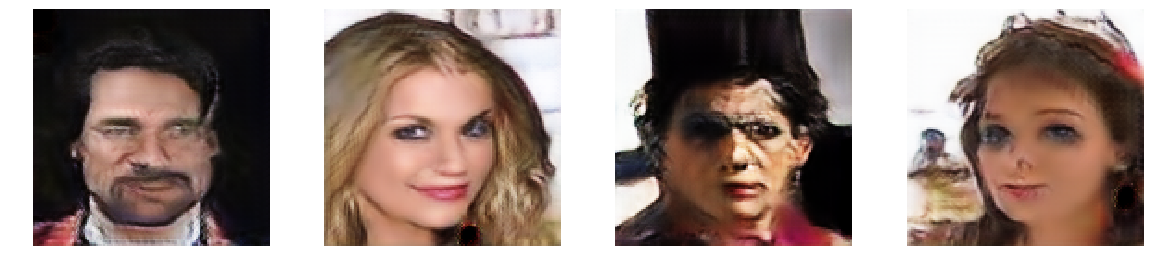


 60%|██████    | 33000/55000 [20:56:09<16:51:27,  2.76s/it]

Time for step 33000 is 3.8697783946990967 sec



 60%|██████    | 33260/55000 [21:05:49<13:34:55,  2.25s/it]


 61%|██████    | 33520/55000 [21:15:28<13:39:55,  2.29s/it]


 61%|██████▏   | 33780/55000 [21:25:02<13:00:16,  2.21s/it]


 62%|██████▏   | 34040/55000 [21:34:43<12:53:26,  2.21s/it]


 62%|██████▏   | 34300/55000 [21:44:24<12:55:19,  2.25s/it]


 63%|██████▎   | 34560/55000 [21:54:05<12:43:28,  2.24s/it]


 63%|██████▎   | 34820/55000 [22:03:47<12:28:38,  2.23s/it]


 64%|██████▍   | 35080/55000 [22:13:29<12:31:28,  2.26s/it]


 64%|██████▍   | 35340/55000 [22:23:10<12:32:13,  2.30s/it]


 65%|██████▍   | 35600/55000 [22:32:51<12:24:35,  2.30s/it]


 65%|██████▌   | 35860/55000 [22:42:31<12:06:54,  2.28s/it]


 66%|██████▌   | 36120/55000 [22:52:12<11:50:56,  2.26s/it]


 66%|██████▌   | 36380/55000 [23:01:53<11:39:04,  2.25s/it]


 67%|██████▋   | 36640/55000 [23:11:33<11:26:19,  2.24s/it]


 67%|██████▋   | 36900/55000 [23:21:15<11:23:34,  2.27s/it]


 68%|██████▊   | 37160/55000 [23:30:57<11:21:15,  2.29s/it]


 68%|██████▊   | 37420/55000 [23:40:39<11:10:44,  2.29s/it]


 69%|██████▊   | 37680/55000 [23:50:20<10:51:58,  2.26s/it]


 69%|██████▉   | 37940/55000 [24:00:00<10:37:22,  2.24s/it]


 69%|██████▉   | 38200/55000 [24:09:40<10:21:50,  2.22s/it]


 70%|██████▉   | 38460/55000 [24:19:20<10:08:35,  2.21s/it]


 70%|██████▉   | 38499/55000 [24:20:47<10:04:21,  2.20s/it]

Step 38500-1 [D loss: -0.473240]
Step 38500-2 [D loss: -0.118488]
Step 38500-3 [D loss: -0.185277]
Step 38500-4 [D loss: -0.659809]
Step 38500-5 [D loss: -1.196791]
Step 38500 [G loss: 25.036211]


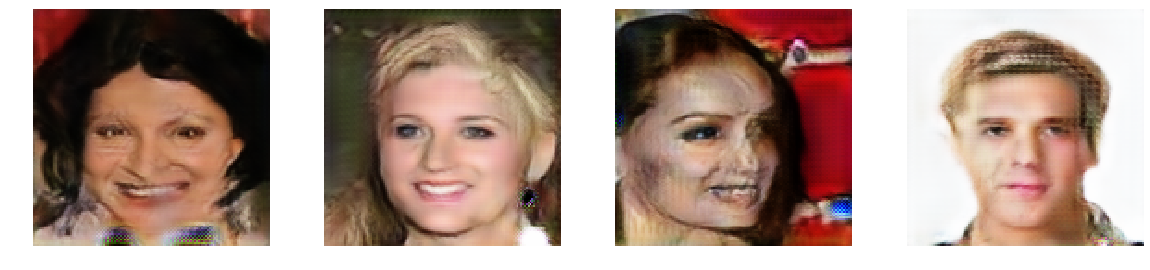


 70%|███████   | 38500/55000 [24:20:51<12:36:26,  2.75s/it]

Time for step 38500 is 4.038605690002441 sec



 70%|███████   | 38760/55000 [24:30:32<9:57:20,  2.21s/it]


 71%|███████   | 39021/55000 [24:40:14<9:49:48,  2.21s/it]


 71%|███████▏  | 39283/55000 [24:50:00<9:43:31,  2.23s/it]


 72%|███████▏  | 39547/55000 [24:59:51<9:46:24,  2.28s/it]


 72%|███████▏  | 39811/55000 [25:09:41<9:24:35,  2.23s/it]


 73%|███████▎  | 40075/55000 [25:19:31<9:11:41,  2.22s/it]


 73%|███████▎  | 40339/55000 [25:29:21<9:17:21,  2.28s/it]


 74%|███████▍  | 40603/55000 [25:39:11<8:53:39,  2.22s/it]


 74%|███████▍  | 40867/55000 [25:49:01<8:38:29,  2.20s/it]


 75%|███████▍  | 41131/55000 [25:58:51<8:35:53,  2.23s/it]


 75%|███████▌  | 41395/55000 [26:08:42<8:27:36,  2.24s/it]


 76%|███████▌  | 41659/55000 [26:18:32<8:20:41,  2.25s/it]


 76%|███████▌  | 41923/55000 [26:28:23<8:04:01,  2.22s/it]


 77%|███████▋  | 42187/55000 [26:38:34<9:06:17,  2.56s/it]


 77%|███████▋  | 42451/55000 [26:49:32<7:57:39,  2.28s/it]


 78%|███████▊  | 42715/55000 [26:59:22<7:30:05,  2.20s/it]


 78%|███████▊  | 42979/55000 [27:09:13<7:24:22,  2.22s/it]


 79%|███████▊  | 43243/55000 [27:19:02<7:10:46,  2.20s/it]


 79%|███████▉  | 43507/55000 [27:28:52<7:14:46,  2.27s/it]


 80%|███████▉  | 43771/55000 [27:38:41<7:01:30,  2.25s/it]


 80%|███████▉  | 43999/55000 [27:47:10<6:41:26,  2.19s/it]

Step 44000-1 [D loss: -0.488259]
Step 44000-2 [D loss: -0.320686]
Step 44000-3 [D loss: -0.442127]
Step 44000-4 [D loss: -0.001548]
Step 44000-5 [D loss: -0.475715]
Step 44000 [G loss: 27.855461]


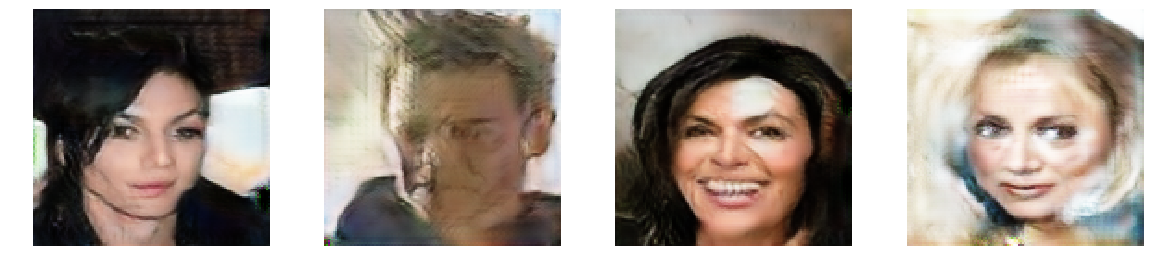


 80%|████████  | 44000/55000 [27:47:15<9:06:26,  2.98s/it]

Time for step 44000 is 4.823981761932373 sec



 80%|████████  | 44264/55000 [27:57:06<6:47:31,  2.28s/it]


 81%|████████  | 44528/55000 [28:06:55<6:25:23,  2.21s/it]


 81%|████████▏ | 44792/55000 [28:16:45<6:16:37,  2.21s/it]


 82%|████████▏ | 45056/55000 [28:26:36<6:15:02,  2.26s/it]


 82%|████████▏ | 45320/55000 [28:36:26<5:53:57,  2.19s/it]


 83%|████████▎ | 45584/55000 [28:46:14<5:55:54,  2.27s/it]


 83%|████████▎ | 45848/55000 [28:56:02<5:43:02,  2.25s/it]


 84%|████████▍ | 46112/55000 [29:05:48<5:23:40,  2.19s/it]


 84%|████████▍ | 46376/55000 [29:15:30<5:18:09,  2.21s/it]


 85%|████████▍ | 46640/55000 [29:25:12<5:07:50,  2.21s/it]


 85%|████████▌ | 46904/55000 [29:35:00<5:01:53,  2.24s/it]


 86%|████████▌ | 47168/55000 [29:44:50<4:50:12,  2.22s/it]


 86%|████████▌ | 47432/55000 [29:54:40<4:48:09,  2.28s/it]


 87%|████████▋ | 47696/55000 [30:04:30<4:30:08,  2.22s/it]


 87%|████████▋ | 47960/55000 [30:14:20<4:22:42,  2.24s/it]


 88%|████████▊ | 48224/55000 [30:24:09<4:16:17,  2.27s/it]


 88%|████████▊ | 48488/55000 [30:33:59<4:02:36,  2.24s/it]


 89%|████████▊ | 48752/55000 [30:43:49<3:52:33,  2.23s/it]


 89%|████████▉ | 49016/55000 [30:53:38<3:40:11,  2.21s/it]


 90%|████████▉ | 49280/55000 [31:03:29<3:36:10,  2.27s/it]


 90%|████████▉ | 49499/55000 [31:11:37<3:26:05,  2.25s/it]

Step 49500-1 [D loss: -0.421116]
Step 49500-2 [D loss: -0.819016]
Step 49500-3 [D loss: -0.280844]
Step 49500-4 [D loss: -0.483410]
Step 49500-5 [D loss: -0.649251]
Step 49500 [G loss: 24.002489]


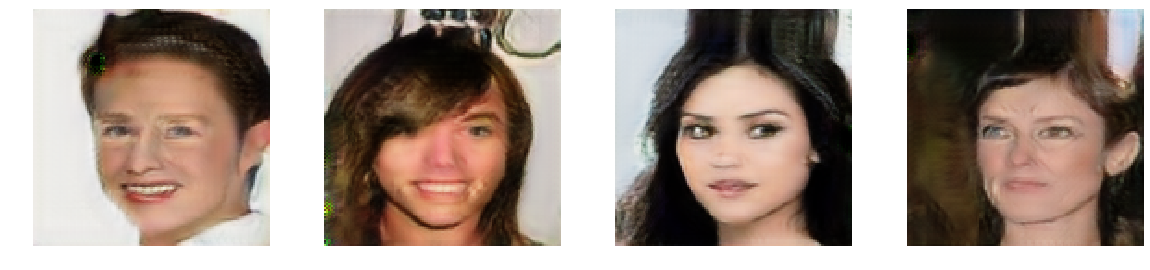


 90%|█████████ | 49500/55000 [31:11:45<5:54:24,  3.87s/it]

Time for step 49500 is 7.638926982879639 sec



 90%|█████████ | 49764/55000 [31:21:36<3:12:00,  2.20s/it]


 91%|█████████ | 50028/55000 [31:31:25<3:02:01,  2.20s/it]


 91%|█████████▏| 50292/55000 [31:41:16<2:59:57,  2.29s/it]


 91%|█████████▏| 50324/55000 [31:42:28<2:53:37,  2.23s/it]

In [ ]:
total_step = 5500*10
loss_print_period = 5500 # 1d
image_saving_period = 5500
lambda_cls = 1
lambda_rec = 10    
lambda_gp = 10
train(train_iterator =train_iterator , test_iterator=test_iterator, total_step=total_step, train_batch_size=train_batch_size, discriminator_updates=5, saving_folder = '/home/Markkim/stargan2', image_saving_period=image_saving_period)

#### Inference

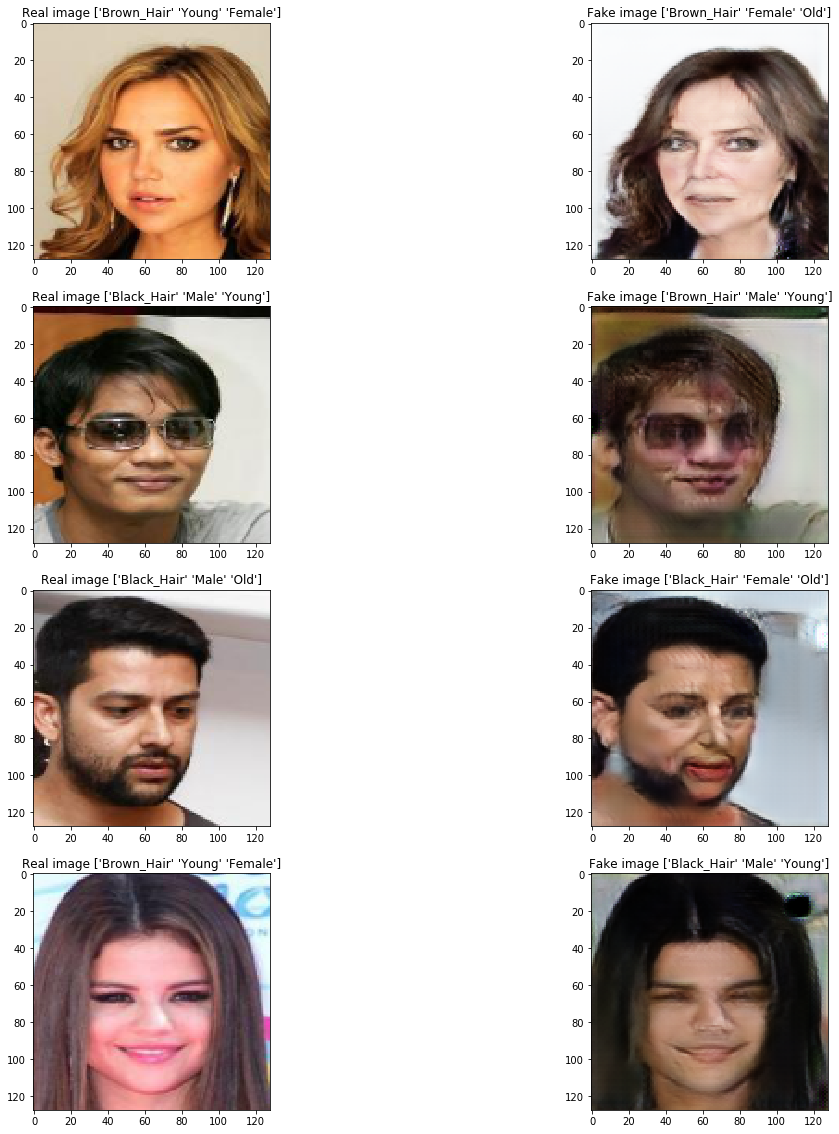

In [220]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

for a ,b in test_dataset.take(1):
    test_original_images = a
    test_original_domains = b
    
test_target_domain = random_target_domain_generation(4)
test_result = generator(test_images, test_target_domain)  

fig, ax = plt.subplots(4,2, figsize=(20,20))
for i in range(4):
    for j in range(2):
        if  j == 0:
            ax[i,j].imshow(test_images[i]*0.5 + 0.5)
            ax[i,j].set_title('Real image {}'.format(lookup(test_original_domains[i])))
        if  j > 0:
            ax[i,j].imshow(test_result[i]*0.5 + .5)
            ax[i,j].set_title('Fake image {}'.format(lookup(test_target_domain[i])))
    plt.subplots_adjust(wspace=0, hspace=0.2)

            